# Проект "Промышленность"

## Введение

Основываясь на данных заказчика требуется создать модель, предсказывающую температуру сплава стали в результате одного из этпаов ее обработки.

Описание технологического процесса:
- прогрев сырьевой стали графитовыми электродами (таблица acr с указанием затраченной мощности и затраченного времени)
- продвув сплава инертным газом (таблица gas с указанием затраченного объема газа)
- легирование стали сыпучими материалами и/или проволокой (таблицы wire и bulk с указанием типа конкретной добаки и использованного объема, а также соответствующие таблицы с суффиксом time с указанием даты и времени внесения добаки)
- число циклов различно для различных партий
- добавление лигирующих добавок зависит от текущего химического состава стали. Пропорции и виды добавок зависят как раз от него. Этот процесс не обязательный, если сталь поступила с уже требуемым хим. составом.

## Импорт библиотек. Загрузка данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.inspection import permutation_importance

RANDOM_STATE = 19092022

In [2]:
try:
    arc = pd.read_csv('data_arc.csv')
    bulk = pd.read_csv('data_bulk.csv')
    bulk_time = pd.read_csv('data_bulk_time.csv')
    gas = pd.read_csv('data_gas.csv')
    temp = pd.read_csv('data_temp.csv')
    wire = pd.read_csv('data_wire.csv')
    wire_time = pd.read_csv('data_wire_time.csv')
except:
    arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Для дальнейшего удобоства и единообразия изменим рускоязычные заголовки столбцов на англоязычные.

In [3]:
arc.columns = ['key', 'start_of_heating', 'end_of_heating', 'active_power', 'reactive_power']
bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']
bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']
wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']
wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']
gas.columns = ['key', 'gas_1']
temp.columns = ['key', 'measurement_time', 'temperature']

## Обзор данных

### data_arc

In [4]:
arc.head()

,key,start_of_heating,end_of_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14876 non-null  int64  
 1   start_of_heating  14876 non-null  object 
 2   end_of_heating    14876 non-null  object 
 3   active_power      14876 non-null  float64
 4   reactive_power    14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Отрицательное значение потребленной реативной мощности говорит о выбросе.

In [7]:
arc[arc['reactive_power'] < 0]

,key,start_of_heating,end_of_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [8]:
arc[arc['key'] == 2116]

,key,start_of_heating,end_of_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [9]:
print('Самая ранняя указанная дата:', arc['start_of_heating'].min())
print('Самая поздняя указанная дата:', arc['start_of_heating'].max())

Самая ранняя указанная дата: 2019-05-03 11:02:14
Самая поздняя указанная дата: 2019-09-01 04:34:47


In [10]:
print('Самая ранняя указанная дата:', arc['end_of_heating'].min())
print('Самая поздняя указанная дата:', arc['end_of_heating'].max())

Самая ранняя указанная дата: 2019-05-03 11:06:02
Самая поздняя указанная дата: 2019-09-01 04:36:08


Все даты находятся в диапазоне между маем и сентябрем 2019

In [11]:
(arc['start_of_heating'] <= arc['end_of_heating']).unique()

array([ True])

Даты начала и конца нагрева указаны корректно. Начало раньше окончания.

In [12]:
arc.groupby('key').count().describe()

,start_of_heating,end_of_heating,active_power,reactive_power
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,4.628500,4.628500,4.628500,4.628500
std,1.608647,1.608647,1.608647,1.608647
min,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000
50%,4.000000,4.000000,4.000000,4.000000
75%,6.000000,6.000000,6.000000,6.000000
max,16.000000,16.000000,16.000000,16.000000


Количество нагревов изменялось от партии к партии.

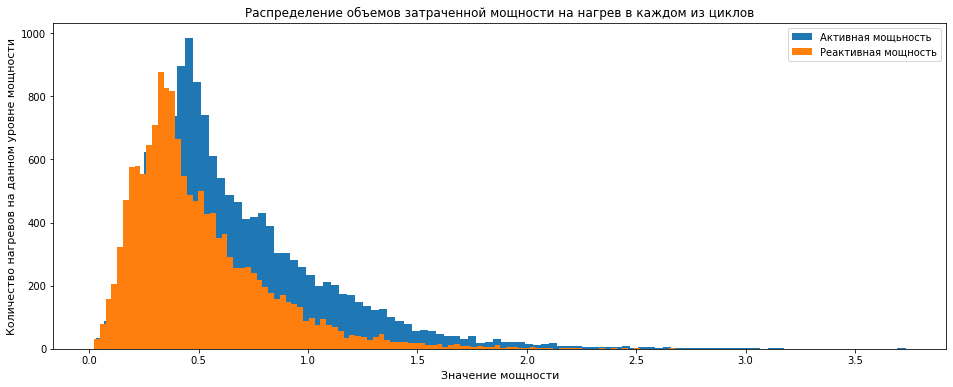

In [13]:
plt.figure(figsize=(16, 6))
plt.title('Распределение объемов затраченной мощности на нагрев в каждом из циклов')
plt.xlabel('Значение мощности', fontsize=11)
plt.ylabel('Количество нагревов на данном уровне мощности', fontsize=11)
_1 = plt.hist(arc['active_power'], bins=100, label='Активная мощьность')
_2 = plt.hist(arc[arc['reactive_power'] >= 0]['reactive_power'], bins=100, label='Реактивная мощность')
plt.legend()

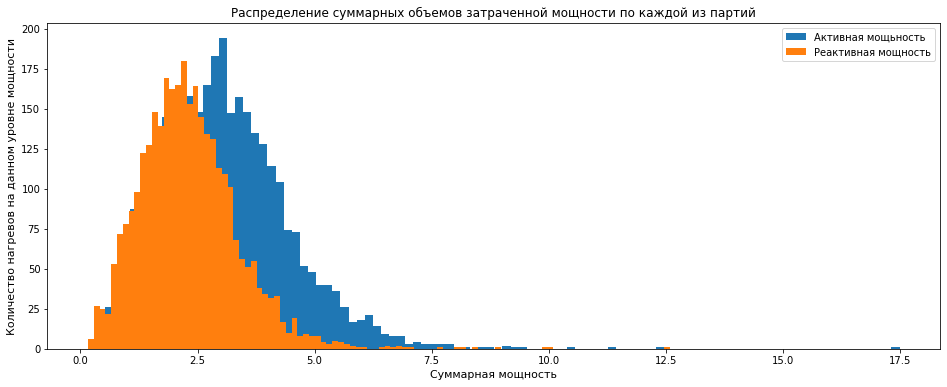

In [14]:
plt.figure(figsize=(16, 6))
plt.title('Распределение суммарных объемов затраченной мощности по каждой из партий')
plt.xlabel('Суммарная мощность', fontsize=11)
plt.ylabel('Количество нагревов на данном уровне мощности', fontsize=11)
_1 = plt.hist(arc.groupby('key').sum()['active_power'], bins=100, label='Активная мощьность')
_2 = plt.hist(arc[arc['reactive_power'] >= 0].groupby('key').sum()['reactive_power'], 
              bins=100, label='Реактивная мощность')
plt.legend()

Не обнаружено других выбросов.

In [15]:
len(arc['key'].unique())

3214

Всего уникальных партий 3214.

### data_bulk, data_bulk_time

In [16]:
bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [17]:
bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [18]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [19]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [20]:
(bulk.isnull() != bulk_time.isnull()).astype(int).sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

Ячейки с пропущенными значениями между двумя таблицами совпадают. Т.е. нет таких данных в одной таблице, для которых не найдутся данные в соответствующей ячейке в другой таблице

In [21]:
print('Самая ранняя указанная дата:', bulk_time.iloc[:, 1:17].apply(pd.to_datetime).min().min())
print('Самая поздняя указанная дата:', bulk_time.iloc[:, 1:17].apply(pd.to_datetime).max().max())

Самая ранняя указанная дата: 2019-05-03 11:03:52
Самая поздняя указанная дата: 2019-09-01 04:05:34


Даты так же находятся в пределах диапазона май - сентябрь 2019

In [22]:
sum_bulks = bulk.iloc[:,1:17].sum()
sum_bulks

bulk_1       9889.0
bulk_2       5567.0
bulk_3     147815.0
bulk_4     105856.0
bulk_5       8241.0
bulk_6      68501.0
bulk_7       7640.0
bulk_8         49.0
bulk_9       1450.0
bulk_10     14658.0
bulk_11     13597.0
bulk_12    638154.0
bulk_13      3260.0
bulk_14    477819.0
bulk_15    360834.0
dtype: float64

<BarContainer object of 15 artists>

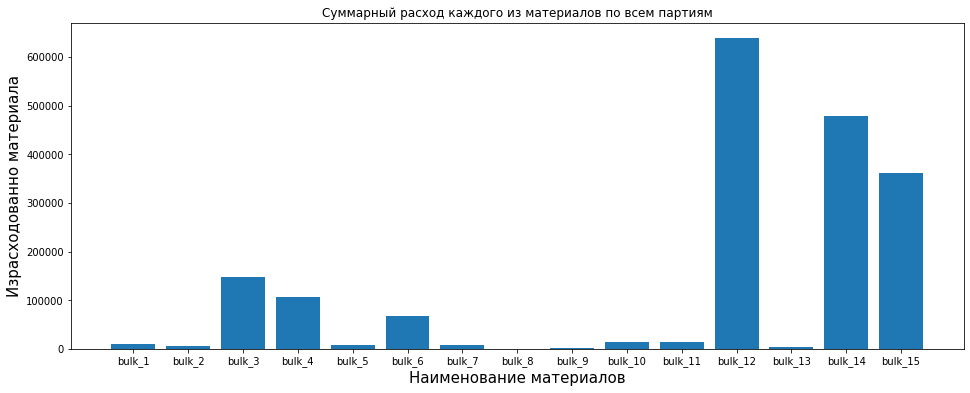

In [23]:
plt.figure(figsize=(16, 6))
plt.title('Суммарный расход каждого из материалов по всем партиям')
plt.xlabel('Наименование материалов', fontsize=15)
plt.ylabel('Израсходованно материала', fontsize=15)
plt.bar(sum_bulks.index, sum_bulks)

Материалы 12, 14 и 15 используются чаще остальных. Несколько материалов искользуются крайне редко. Учитывая различные физические свойства можно предположить, что использование различных лигирующих добавок может по-разному влиять на процессы нагревания и остывания стали.

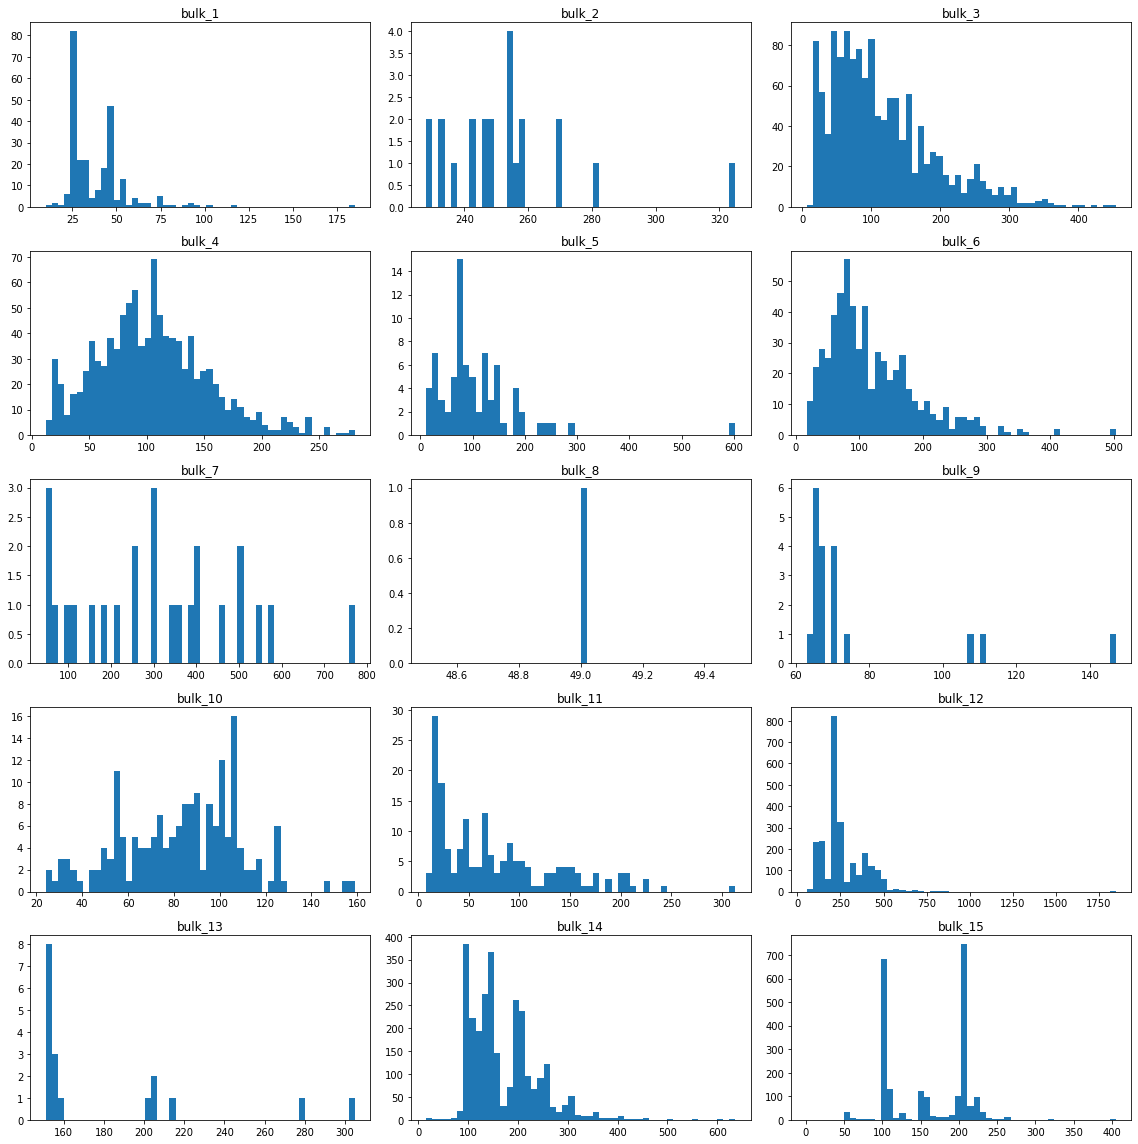

In [24]:
fig, axs = plt.subplots(5, 3, figsize=(16, 16))
k = 1
for ax in axs.flat:
    ax.set_title('bulk_' + str(k))
    ax.hist(bulk.iloc[:, k], bins=50)
    k += 1
fig.tight_layout()

Графики показывают различное распределение для каждой добавки. По материалам, таким как bulk_2 и bulk_7, дискретность графиков демонстрирует их редкое использование. Более часто используемые материалы, такие как 3, 4 и 6 показывают более случайные распределения. В графиках материалов 12 и 15 сильно выделяются наиболее распространенные дозировки соответствующих компонентов. На данный момент сложно оценить можно ли использовать полученные данные. Возможно вернемся к ним позже для более подробного анализа влияния тех или иных добавок на итоговый результат.

In [25]:
len(bulk['key'].unique())

3129

Количество уникальных значений партий 3129. Выбросов не обнаружено.

### data_wire, data_wire_time

In [26]:
wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [28]:
wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [29]:
wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
(wire.isnull() != wire_time.isnull()).astype(int).sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

In [31]:
print('Самая ранняя указанная дата:', wire_time.iloc[:, 1:10].apply(pd.to_datetime).min().min())
print('Самая поздняя указанная дата:', wire_time.iloc[:, 1:10].apply(pd.to_datetime).max().max())

Самая ранняя указанная дата: 2019-05-03 11:11:41
Самая поздняя указанная дата: 2019-09-01 04:16:01


Все даты так же вписываются в найденный ранее диапазон май - сентбярь 2019

In [32]:
sum_wires = wire.iloc[:,1:10].sum()
sum_wires

wire_1    308236.830606
wire_2     54572.931650
wire_3     11937.408916
wire_4       804.199781
wire_5        15.132000
wire_6      3505.239099
wire_7       110.429080
wire_8      1018.878666
wire_9       990.516814
dtype: float64

<BarContainer object of 9 artists>

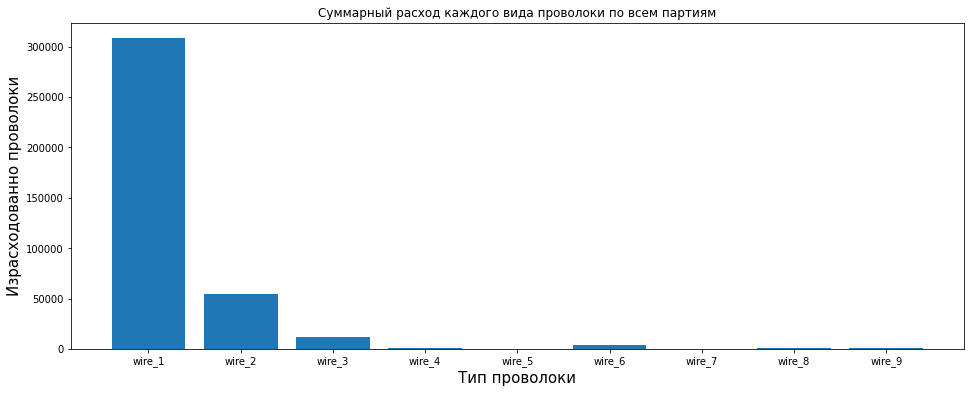

In [33]:
plt.figure(figsize=(16, 6))
plt.title('Суммарный расход каждого вида проволоки по всем партиям')
plt.xlabel('Тип проволоки', fontsize=15)
plt.ylabel('Израсходованно проволоки', fontsize=15)
plt.bar(sum_wires.index, sum_wires)

Аналогично сухим материалам, можно выделить тип проволоки используемой в значительно больших объемах чем другие.

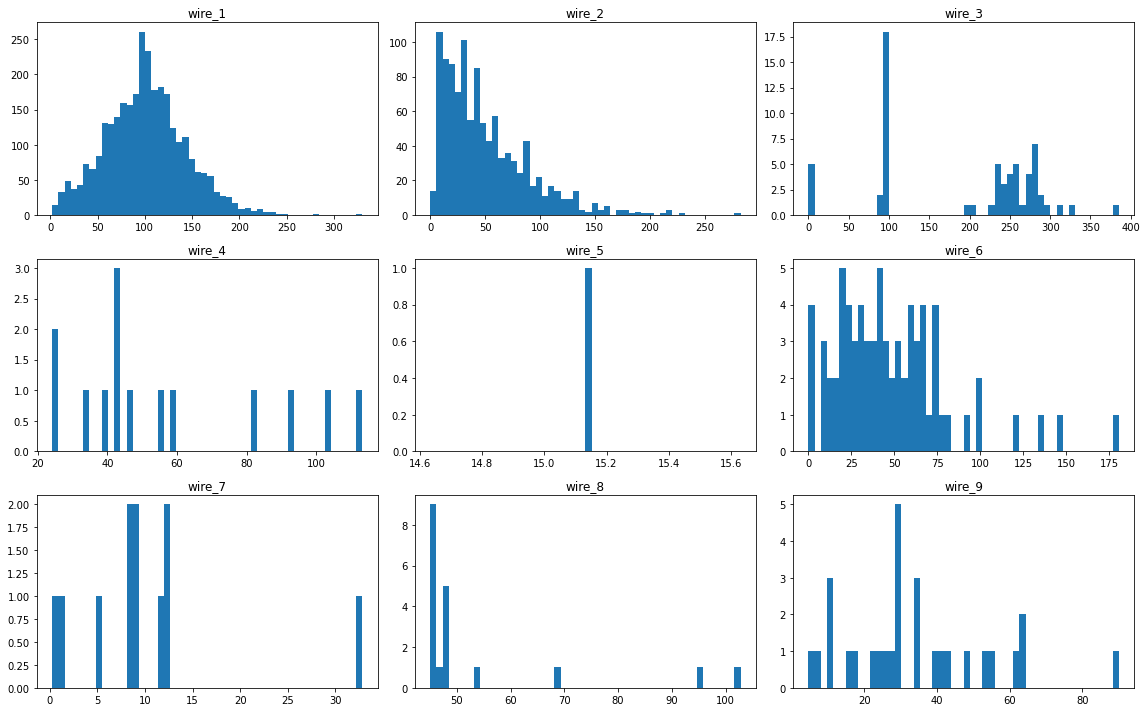

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))
k = 1
for ax in axs.flat:
    ax.set_title('wire_' + str(k))
    ax.hist(wire.iloc[:, k], bins=50)
    k += 1
fig.tight_layout()

In [35]:
len(wire['key'].unique())

3081

Всего 3081 уникальный id партии.

### data_gas

In [36]:
gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [37]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [38]:
gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Выбросов в данных не наблюдается

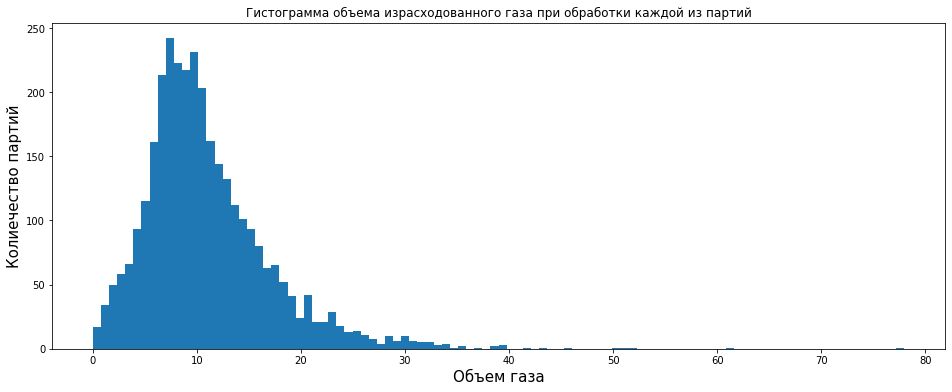

In [39]:
plt.figure(figsize=(16, 6))
plt.title('Гистограмма объема израсходованного газа при обработки каждой из партий')
plt.xlabel('Объем газа', fontsize=15)
plt.ylabel('Колиечество партий', fontsize=15)
_ = plt.hist(gas['gas_1'], bins=100)

Сложно судить, являются ли значения более 40 выбросами. Возможно стоит уточнить этот вопрос у заказчика.

In [40]:
gas[gas['gas_1'] > 40]

,key,gas_1
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


In [41]:
len(gas['key'].unique())

3239

### data_temp

In [42]:
temp.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [43]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               15907 non-null  int64  
 1   measurement_time  15907 non-null  object 
 2   temperature       13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [44]:
temp[temp['temperature'].isnull()]

,key,measurement_time,temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Данные по температуре отсутствуют в части ячеек начиная с партии 2500

In [45]:
temp.describe()

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Выбросов по значениям температуры не выявлено.

In [46]:
temp[temp['temperature'].isnull() == False].groupby('key').count()

,measurement_time,temperature
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
...,...,...
3237,1,1
3238,1,1
3239,1,1


3216 уникальных партий

In [47]:
temp_count = temp[temp['key'] < 2500].groupby('key').count()
temp_count[temp_count['temperature'] == 1]

,measurement_time,temperature
key,,
195,1,1
279,1,1


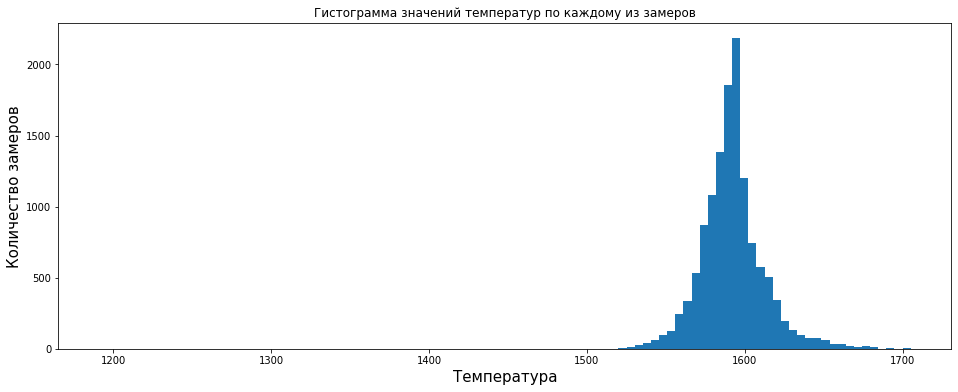

In [48]:
temp_fill = temp[temp['temperature'].isnull() == False]
plt.figure(figsize=(16, 6))
plt.title('Гистограмма значений температур по каждому из замеров')
plt.xlabel('Температура', fontsize=15)
plt.ylabel('Количество замеров', fontsize=15)
_ = plt.hist(temp_fill['temperature'], bins=100)

Возможно стоит также обратить внимание на партии с температурами ниже 1500.

In [49]:
temp[temp['temperature'] < 1500]

,key,measurement_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


### Данные всех таблиц по одной из партий

Для общего представления о полном цикле нагрева и легирования партии выделим данные по одной и той же партии из каждой таблицы

In [50]:
i = 808
display(arc[arc['key'] == i])
display(bulk[bulk['key'] == i])
display(bulk_time[bulk_time['key'] == i])
display(gas[gas['key'] == i])
display(temp[temp['key'] == i])
display(wire[wire['key'] == i])
display(wire_time[wire_time['key'] == i])

,key,start_of_heating,end_of_heating,active_power,reactive_power
3727,808,2019-06-02 08:16:19,2019-06-02 08:18:23,0.386772,0.250064
3728,808,2019-06-02 08:22:39,2019-06-02 08:24:03,0.293113,0.198911
3729,808,2019-06-02 08:25:26,2019-06-02 08:28:13,0.597251,0.474909
3730,808,2019-06-02 08:29:27,2019-06-02 08:30:51,0.307462,0.197667
3731,808,2019-06-02 08:36:19,2019-06-02 08:38:36,0.508354,0.313811
3732,808,2019-06-02 08:41:02,2019-06-02 08:46:24,1.155499,0.729536
3733,808,2019-06-02 08:47:39,2019-06-02 08:49:56,0.507448,0.319619
3734,808,2019-06-02 08:56:56,2019-06-02 08:58:02,0.245731,0.157699


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
774,808,NaN,NaN,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN,153.0,154.0


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
774,808,NaN,NaN,2019-06-02 08:36:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-02 08:24:14,NaN,2019-06-02 08:24:14,2019-06-02 08:24:14


,key,gas_1
805,808,17.293232


,key,measurement_time,temperature
4062,808,2019-06-02 08:19:20,1580.0
4063,808,2019-06-02 08:20:17,1564.0
4064,808,2019-06-02 08:40:51,1573.0
4065,808,2019-06-02 08:51:27,1600.0
4066,808,2019-06-02 08:56:40,1594.0
4067,808,2019-06-02 08:59:36,1593.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
755,808,193.377594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
755,808,2019-06-02 08:35:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Выводы. Вопросы. Предлагаемый план

### Выводы:

- Обнаружены следующие особенности, требуещие уточнений или корректировки: отрицательное значение реактивной мощности по одной из партий, 8 значение замерянной температуры ниже порока в 1500C, отсутствие замеров температуры, кроме первого, по всем партиям начиная с 2500.
- В разных файлах разное количество уникальных партий. Минимальное в wire.

### План работы:

<b>1. Предобработка данных</b>
- По согласованию с заказчиком: удалим данны по партиям начиная с индекса 2500; по партиям, со значениями темератур ниже 1500; с отрицательной реактивной мощностью; партии с единственным замером темературы.
- В таблицах об объемах добавляемых легирующих элементов заменим пропуски на 0.
- В качестве целевого признака используем последнюю из измеренных температур по каждой партии. 
- В качестве дополнительных признаков выделим: первый замер температуры каждой из партий; продолжнительность нагрева; количество циклов нагрева.
- Полученные таблицы объединим в единую по индексу партии. 

<b>2. Подготовка к обучению, обучение, выбор лучше модели</b>
- Разделим новый датафрейм на обучающую и тестовую выборки.
- Анализ корреляции между признаками.
- Для сравнения и выбора наиболее точной модели выбирем Линейную регрессию, Случайный лес, Catboost.
- Для обучения линейных моделей приведем данные к одному масштабу.
- Подбор гиперпараметров с применением инструментов GridSearchCV либо RandomSearchCV.
- Сравнение полученной модели с результатами Dummy-модели.
- Исследование важности признаков.

<b>3. Тестирование модели</b>
- Проверить результат предсказаний выбранной модели на тестовых данных.

<b>4. Отчет</b>
- Описание процесса подготовки данных, выбранной модели, выбранных гиперпараметров.

## Предобработка данных

### Удаление некорректных данных, генерация новых признаков, объединение признаков в одну таблицу

In [51]:
# Удаляем партии с отрицательной мощностью, индексами от 2500, а так же с однократными измерениями температуры.
arc = arc.drop(arc[arc['key'] == 2116].index)
arc = arc.drop(arc[arc['key'] >= 2500].index)
arc = arc.drop(arc[(arc['key'] == 195) | (arc['key'] == 279)].index)

In [52]:
arc['start_of_heating'] = pd.to_datetime(arc['start_of_heating'])
arc['end_of_heating'] = pd.to_datetime(arc['end_of_heating'])
arc['heating_time'] = arc['end_of_heating'] - arc['start_of_heating']

In [53]:
# Выедлим следующие признаки: суммарныя активная и реактивная мощность по каждой партии, количество и продолжительность нагревов в партии, 
arc = arc.groupby('key').agg(
    start_party=pd.NamedAgg(column='start_of_heating', aggfunc='min'),
    end_party=pd.NamedAgg(column='end_of_heating', aggfunc='max'),
    mean_active_power=pd.NamedAgg(column='active_power', aggfunc='mean'),
    mean_reactive_power=pd.NamedAgg(column='reactive_power', aggfunc='mean'),
    number_of_heatings=pd.NamedAgg(column='key', aggfunc='count'),
    heating_duration=pd.NamedAgg(column='heating_time', aggfunc='sum'))

arc['time_without_heating'] = arc['end_party'] - arc['start_party'] - arc['heating_duration']
arc['time_without_heating'] = arc['time_without_heating'].dt.total_seconds()
arc['heating_duration'] = arc['heating_duration'].dt.total_seconds()

arc = arc.drop(['start_party', 'end_party'], axis=1)
arc.head()

,mean_active_power,mean_reactive_power,number_of_heatings,heating_duration,time_without_heating
key,,,,,
1,0.975629,0.636648,5,1098.0,485.0
2,0.763150,0.499528,4,811.0,333.0
3,0.505176,0.319815,5,655.0,870.0
4,0.802313,0.515074,4,741.0,352.0
5,0.836793,0.563161,4,869.0,493.0


In [54]:
# Заменяем пропуски нулями
bulk = bulk.fillna(0)
wire = wire.fillna(0)

In [55]:
# Удаляем партии, в которых были обнаружены значения температуры ниже 1500
keys_1500 = temp[temp['temperature'] < 1500]['key'].to_list()
temp = temp.drop(temp[temp['key'].isin(keys_1500)].index)

# Удаляем партии с отрицательной мощностью, индексами от 2500, а так же с однократными измерениями температуры.
temp = temp.drop(temp[(temp['key'] == 2116) | (temp['key'] == 195) | (temp['key'] == 279) | (temp['key'] >= 2500)].index)

# Используя промежуточне таблицы выделяем первую измеренную температуру каждой партии как дополнительный признак
tmp_temp = temp.sort_values(['key', 'measurement_time'], ascending=True)
min_idx = tmp_temp.index.to_series().groupby(tmp_temp['key']).agg('first')

# ...и последнюю, как целевой признак.
tmp_temp = temp.sort_values(['key', 'measurement_time'], ascending=False)
max_idx = tmp_temp.index.to_series().groupby(tmp_temp['key']).agg('first')

target = temp.loc[max_idx].drop('measurement_time', axis=1).reset_index(drop=True)
target.head()

,key,temperature
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


In [56]:
temp_features = temp.loc[min_idx].drop('measurement_time', axis=1).reset_index(drop=True)
temp_features.head()

,key,temperature
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


In [57]:
features = (
    arc
 .merge(bulk, how='inner', on='key')
 .merge(wire, how='inner', on='key')
 .merge(gas, how='inner', on='key')
 .merge(temp_features, how='inner', on='key')
 .merge(target, how='inner', on='key')
)
features = features.drop('key', axis=1)
features.head()

,mean_active_power,mean_reactive_power,number_of_heatings,heating_duration,time_without_heating,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,temperature_x,temperature_y
0,0.975629,0.636648,5,1098.0,485.0,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,0.763150,0.499528,4,811.0,333.0,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
2,0.505176,0.319815,5,655.0,870.0,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
3,0.802313,0.515074,4,741.0,352.0,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
4,0.836793,0.563161,4,869.0,493.0,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0


### Визуализация полученных данных

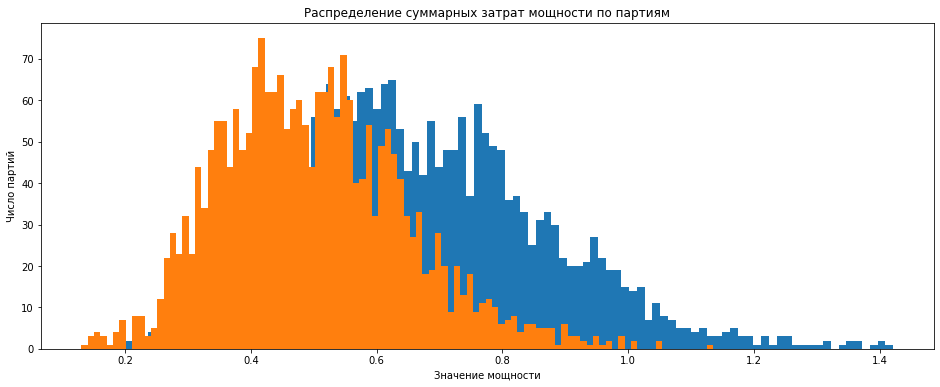

In [58]:
plt.figure(figsize=(16, 6))
plt.title('Распределение суммарных затрат мощности по партиям')
plt.xlabel('Значение мощности')
plt.ylabel('Число партий')
_ = plt.hist(features['mean_active_power'], bins=100)
_ = plt.hist(features['mean_reactive_power'], bins=100)

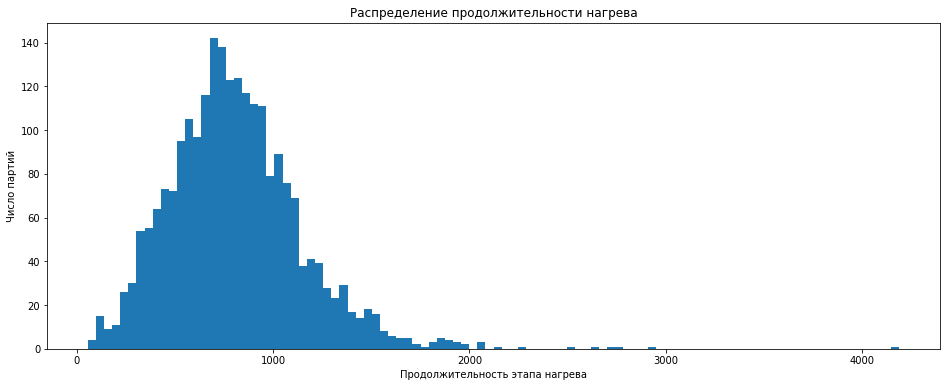

In [59]:
plt.figure(figsize=(16, 6))
plt.title('Распределение продолжительности нагрева')
plt.xlabel('Продолжительность этапа нагрева')
plt.ylabel('Число партий')
_ = plt.hist(features['heating_duration'], bins=100)

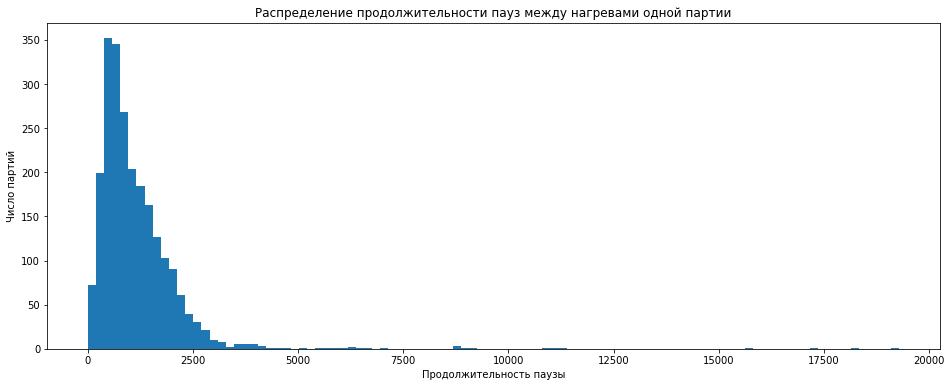

In [60]:
plt.figure(figsize=(16, 6))
plt.title('Распределение продолжительности пауз между нагревами одной партии')
plt.xlabel('Продолжительность паузы')
plt.ylabel('Число партий')
_ = plt.hist(features['time_without_heating'], bins=100)

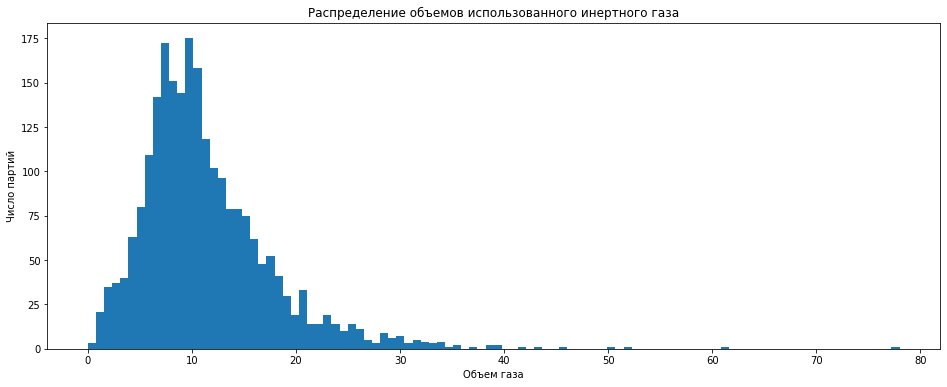

In [61]:
plt.figure(figsize=(16, 6))
plt.title('Распределение объемов использованного инертного газа')
plt.xlabel('Объем газа')
plt.ylabel('Число партий')
_ = plt.hist(features['gas_1'], bins=100)

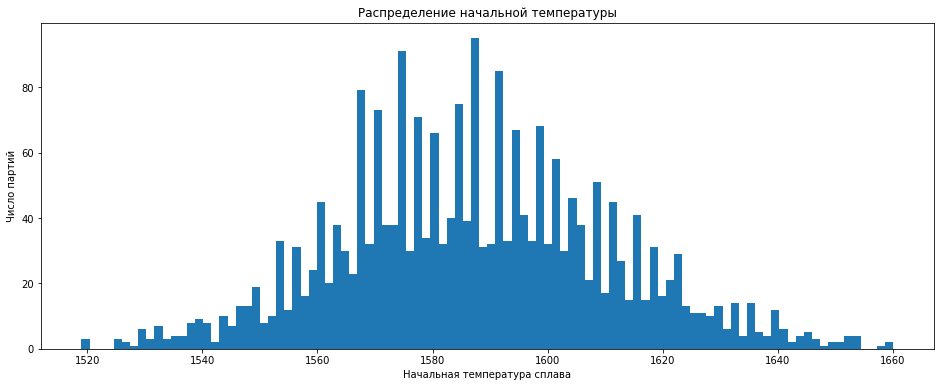

In [62]:
plt.figure(figsize=(16, 6))
plt.title('Распределение начальной температуры')
plt.xlabel('Начальная температура сплава')
plt.ylabel('Число партий')
_ = plt.hist(features['temperature_x'], bins=100)

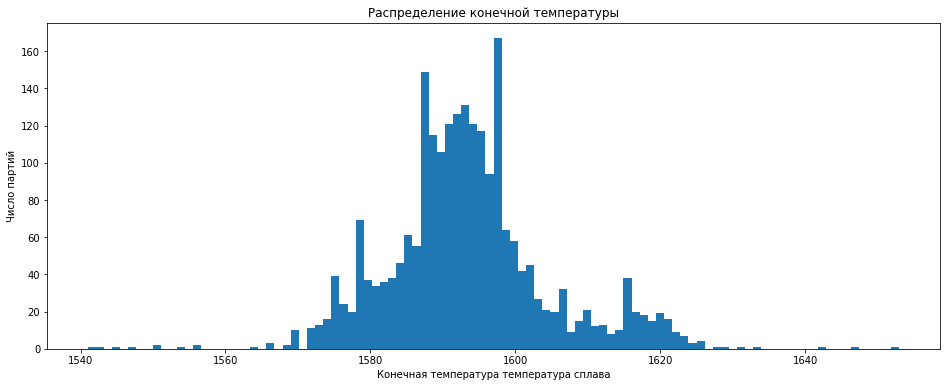

In [63]:
plt.figure(figsize=(16, 6))
plt.title('Распределение конечной температуры')
plt.xlabel('Конечная температура температура сплава')
plt.ylabel('Число партий')
_ = plt.hist(features['temperature_y'], bins=100)

### Корреляция признаков

<AxesSubplot:>

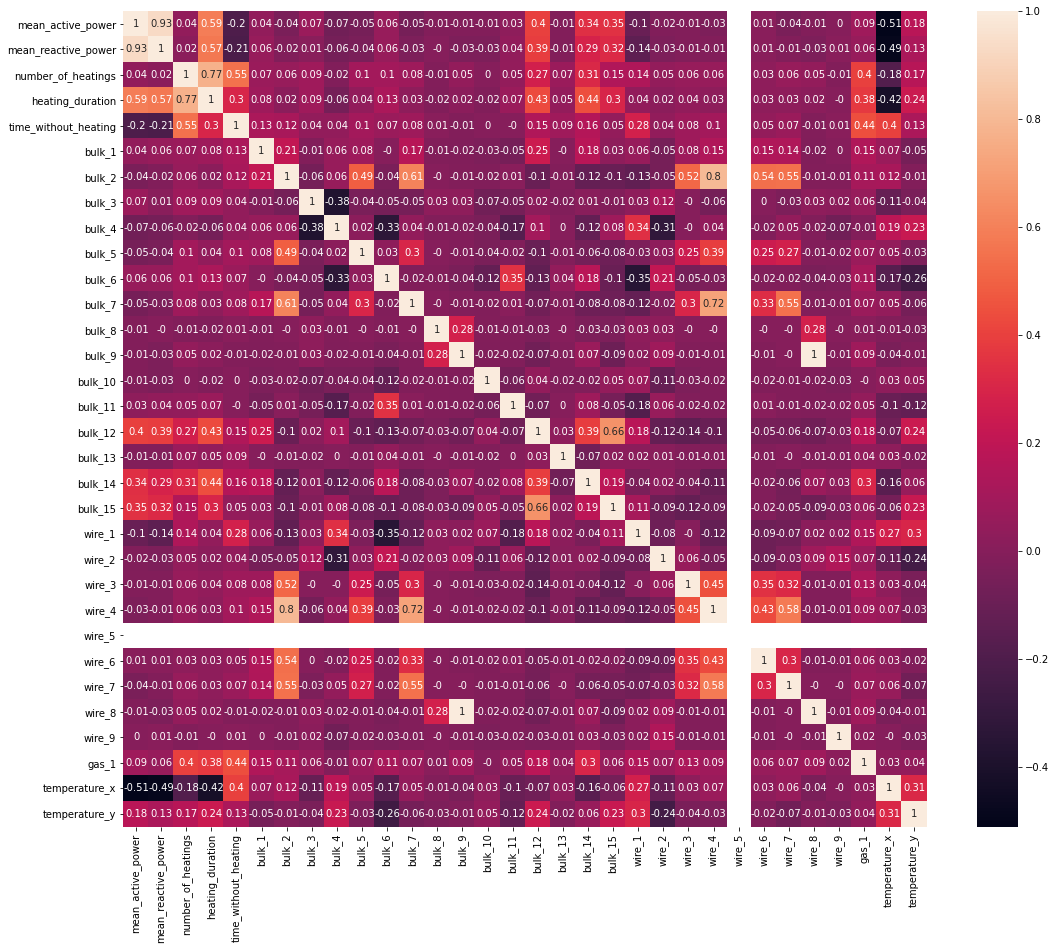

In [67]:
plt.figure(figsize=(18,15))
sns.heatmap(features.corr(method='spearman').round(2), annot=True)

Наибольшая корреляция наблюдается между такими признаками как мощность, количество циклов нагрева, продолжительность нагрева. Выражена обратная корреляция между первоначальной температурой и затраченной мощностью и продолжительностью нагрева. Что понятно: недостаточно нагретый сплав требует больше ресурсов на доведение до необходимой температуры. Видны точечные связи в использовании некоторых легирующих добавок. Проволока wire_5 требует отдельного внимания.

In [27]:
features['wire_5'].describe()

count    2324.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: wire_5, dtype: float64

In [28]:
wire[wire['wire_5'] > 0]

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2440,2567,18.30192,0.0,96.288193,0.0,15.132,73.307526,0.0,0.0,0.0


Во всем датасете данная проволка применялась единожды, причем в партии, оставленной заказчиком для тестирования модели. 
Видимо стоит обратить внимание заказчика на необходимость большего количества данных с применением данного вида проволоки. Т.к. при имеющихся данных наша модель не будет способна предсказать выходные значения при появлении партий с использованием проволки №5.

Т.к. ни осталось ни одной партии с использованием такой проволоки, следует удалить этот столбец из признаков. 

In [29]:
features = features.drop('wire_5', axis=1)
features.head(2)

,mean_active_power,mean_reactive_power,number_of_heatings,heating_duration,time_without_heating,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas_1,temperature_x,temperature_y
0,0.975629,0.636648,5,1098.0,485.0,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,0.763150,0.499528,4,811.0,333.0,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0


Из найденных пар признаков с корреляцией более 0.9, удалим по одному из них. А именно: из пары active_power и reactive_power удалим reactive_power, а из пары bulk_9 и wire_8 удалим wire_8.

In [68]:
features = features.drop(['mean_reactive_power'], axis=1)
features = features.drop(['wire_8'], axis=1)
features.head(2)

,mean_active_power,number_of_heatings,heating_duration,time_without_heating,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,gas_1,temperature_x,temperature_y
0,0.975629,5,1098.0,485.0,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,0.763150,4,811.0,333.0,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0


## Подготовка к обучению. Обучение. Выбор модели.

### Выделение целевого признака. Разделение выборки на обучающую и тестовую. Масштабирование.

In [69]:
target = features['temperature_y']
features = features.drop('temperature_y', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

Для обучения линейных моделей проведем масштабированя признаков. Для сравнения используем два иструмента масштабирования: StandardScaler() и MinMaxScaler()

### Линейная регрессия

In [72]:
model_lr = LinearRegression(normalize=True)
cv_lr = cross_validate(model_lr, features_train, target_train, scoring='neg_mean_absolute_error', cv=4, return_estimator=True)
print('MAE =', round(-cv_lr['test_score'].mean(), 2))

MAE = 5.86


### Случайный лес

In [37]:
parameters = {'n_estimators':list(range(80, 301, 20)),
              'max_depth':list(range(5, 16))}

In [38]:
model_rf = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), parameters, cv=5, scoring='neg_mean_absolute_error')
model_rf.fit(features_train, target_train)
print(model_rf.best_score_)
print(model_rf.best_params_)

-5.916129487045741
{'max_depth': 12, 'n_estimators': 200}


На модели случайного леса удалось достигнуть еще более низкой метрики MAE 2.68, при масштабировании с применением MinMaxScaler() и гиперпараметрах n_estimator = 140, max_depth = 13.

### CatBoost


In [40]:
parameters = {'learning_rate':[.001, .01, .05, .1],
             'iterations':[10, 50, 100]}

In [41]:
a_cat = GridSearchCV(CatBoostRegressor(verbose=False, depth=16), parameters, cv=5, scoring='neg_mean_absolute_error')
a_cat.fit(features_train, target_train)
print(a_cat.best_score_)
print(a_cat.best_params_)

-6.535046517469555
{'iterations': 100, 'learning_rate': 0.1}


### DummyRegressor

In [42]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(features_train, target_train)
predict_dum = dummy_regr.predict(features_test)
mae(predict_dum, target_test)

8.104749462566271

Значение MAE на модели dummy с параметром strategy='mean' может говорить об особенности данных, о довольно не сложной зависимости целевого признака от входных данный, о разбросе целевого признака.

## Проверка наилучшей модели на тестовых данных. Оценка важности признаков.

Лучшее значение MAE достигнуто на модели LinearRegression.

In [43]:
model_for_test = cv_lr['estimator'][0]
predict_test = model_for_test.predict(features_test)
mae(predict_test, target_test)

5.844332071266285

In [97]:
result_pi = permutation_importance(model_for_test, features_test, target_test, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = result_pi.importances_mean.argsort()

<BarContainer object of 27 artists>

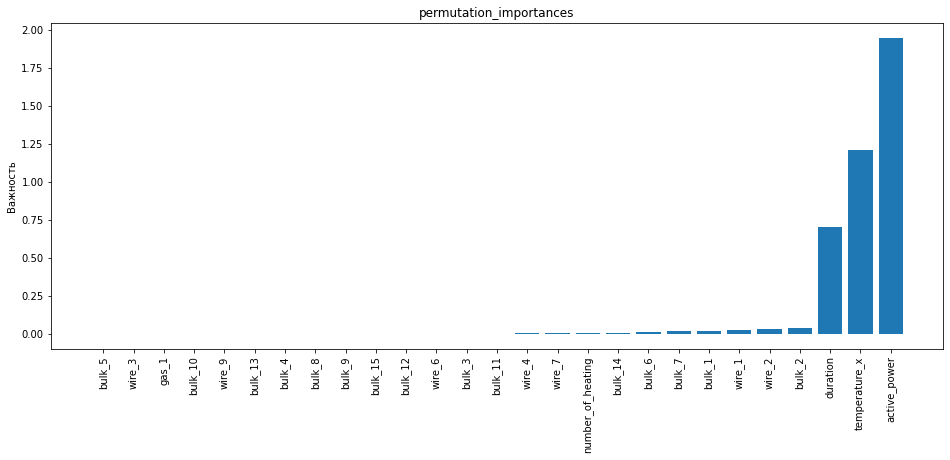

In [101]:
plt.figure(figsize=(16, 6))
plt.title('permutation_importances')
plt.ylabel('Важность')
plt.xticks(rotation=90)
plt.bar(features_train.columns[sorted_idx], result_pi.importances_mean[sorted_idx])

Наиболее важными признаками являются активная мощность, начальная температура и суммарно время нахожденияя сплава на этапе нагрева. 

## Отчет

Ход работы:
- удаление строк с номерами партий от 2500
- удаление строк с индексами 2116 (отрицательная реактивная мощность), 195 и 279 (партии с единственным замером температуры)
- выделение времени начала и окончания каждой партии. Определение суммарного времени нахождения заготовки на изучаемом этапе
- удаление всех партий по которым встречалась температура 1500С
- первую температуру каждой партии переводим в признак обучающей выборки, а последнюю - в целевой признак 
- объединяем все таблицы в одну. В качестве ключа признак 'key'.
- удаляем колонки 'wire_5', 'wire_8', 'reactive_power'
- разделяем признаки на обучающую и тестовую выборки
- использование модели LinearRegression().
- для масштабирования признаков для линейной регрессии применяем нормализацию признаков.


В процессе работы над проектом были реализованы все пункты первоначального плана. В части подготовки данных дополнительно были найдены и удалены две пары признаков имеющих очень высокую тесноту связи.

Некоторые сомнения были на этапе первичного ознакомления с данными. Но позднее, при обсуждении проекта на встрече с тим-лидом, убедился, что в целом большинство идей и предполагаемый ход решения были верными. По итогам встречи удалось упорядочить этапы работы над проектом, а так же составить более подробный план. В ходе же самой работы проявлись пробелы в навыках работы с инструментами масштабирования признаков, а также подбора гиперпараметров, кросс-валидции, оценки важности признаков, поиска мультиколлинеарности. Все необходимые советы получил от старших коллег (ревьюера и тим-лида).

Главными шагами проекта выделил бы анализ данных и разработка детального плана. При предобработке данных крайне важным становится подробная визуализация.

Итоговая модель линейая регрессия с MAE = 5.69.